In [26]:
import tensorflow as tf
import json
import numpy as np
#from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import keras
import json
from keras import layers, models
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

## Load in Data

Get this data from unzipping the folder "LSTM_Inputs" in Google Drive!

In [15]:
size='11x11'
start = datetime.datetime.now()
with open('processed_'+size+'/crashes_4d_24_hour.json', 'r') as f:
    array_4d_list = json.load(f)

# Convert the nested list back to a numpy array
array_4d_24_hour = np.array(array_4d_list)

with open('processed_'+size+'/crashes_4d_one_hour.json', 'r') as f:
    array_4d_list = json.load(f)
array_4d_1_hour = np.array(array_4d_list) 

with open('processed_'+size+'/'+size+'_traffic_1_hour.json', 'r') as f:
    traffic_1_hour_list = json.load(f)
traffic_1_hour = np.array(traffic_1_hour_list) 

with open('processed_'+size+'/'+size+'_traffic_1_hour.json', 'r') as f:
    traffic_1_hour_list = json.load(f)
traffic_1_hour = np.array(traffic_1_hour_list) 

with open('1_hour_weather_data_1_hot.json', 'r') as f:
    traffic_1_hour_list = json.load(f)
weather_1_hour = np.array(traffic_1_hour_list) 

binary_output_1_hour = (array_4d_1_hour > 0).astype(int)
print("Finished Loading in:", datetime.datetime.now()-start)

Finished Loading in: 0:01:54.734507


In [92]:
# Split into training and testing sets with 0.8-0.2
Accident_train, Accident_test, Traffic_train, Traffic_test, Weather_train, Weather_test, Out_train, Out_test, Binary_Out_train, Binary_Out_test = train_test_split(array_4d_24_hour, traffic_1_hour, weather_1_hour, array_4d_1_hour, binary_output_1_hour, test_size=0.2, random_state=42)

## Full Model - Regression

In [90]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(11, 11, 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(11, 11, 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(22, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(64, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)

#Convolution Layers for Traffic
traffic_layer_1 = layers.Conv2D(30, (3, 3), activation='relu')(input_past_traffic_shape)
traffic_layer_2 = layers.MaxPooling2D(pool_size=(3, 1))(traffic_layer_1)
traffic_layer_3 = layers.Flatten()(traffic_layer_2)
traffic_layer_4 = layers.Dense(64, activation='relu')(traffic_layer_3)
traffic_layer_5 = layers.Dense(16, activation='relu')(traffic_layer_3)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, traffic_layer_5, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='linear')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model = Model(inputs=[input_past_accidents_shape, input_past_traffic_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_96      │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 9, 9, 64)  │     13,888 │ input_layer_96[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_68    │ (None, 3, 9, 64)  │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_51          │ (None, 1728)      │          0 │ max_pooling2d_68… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_97      │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 24)        │     41,496 │ flatten_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 9, 9, 30)  │        300 │ input_layer_97[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_98      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_35          │ (None, 24, 1)     │          0 │ dense_153[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_70    │ (None, 3, 9, 30)  │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_157 (Dense)   │ (None, 64)        │      1,472 │ input_layer_98[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 64)        │     16,896 │ reshape_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_52          │ (None, 810)       │          0 │ max_pooling2d_70… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_158 (Dense)   │ (None, 32)        │      2,080 │ dense_157[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 16)        │      1,040 │ lstm_24[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 16)        │     12,976 │ flatten_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_159 (Dense)   │ (None, 16)        │        528 │ dense_158[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_21         │ (None, 16)        │          0 │ dense_154[0][0],  │
│ (Multiply)          │                   │            │ dense_156[0][0],  │
│                     │                   │            │ dense_159[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_160 (Dense)   │ (None, 121)       │      2,057 │ multiply_21[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 11, 11, 1) │          0 │ dense_160[0][0] 

 Total params: 92,733 (362.24 KB)

 Trainable params: 92,733 (362.24 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
## Split into training and testing sets with 0.8-0.2
history = model.fit([Accident_train, Traffic_train, Weather_train], Out_train, epochs=10, batch_size=32)

Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1167 - mae: 0.1452
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1174 - mae: 0.1458
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1183 - mae: 0.1459
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1168 - mae: 0.1454
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1179 - mae: 0.1458
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1174 - mae: 0.1460
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1170 - mae: 0.1453
Epoch 8/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1170 - mae: 0.1455
Epoch 9/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1166 - mae: 0.1452
Epoch 10/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1173 - mae: 0.1457


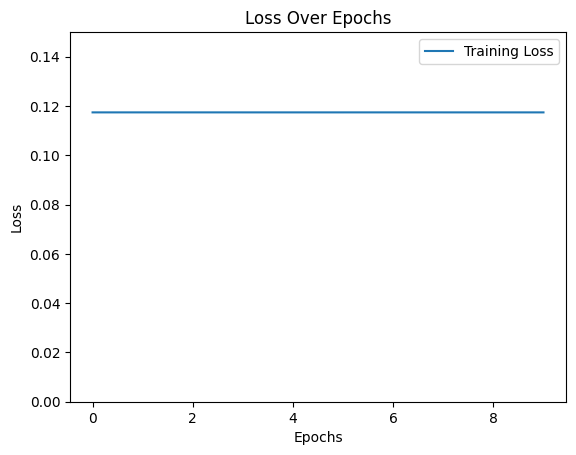

In [94]:
# Extract training and validation losses
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot both
plt.plot(train_loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.ylim(0, 0.15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [95]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Accident_test, Traffic_test, Weather_test], Out_test)

# Print the MAE
print(f"Test MAE: {test_mae}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1184 - mae: 0.1458
Test MAE: 0.1453283578157425


In [96]:
predictions = model.predict([Accident_test, Traffic_test, Weather_test])

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


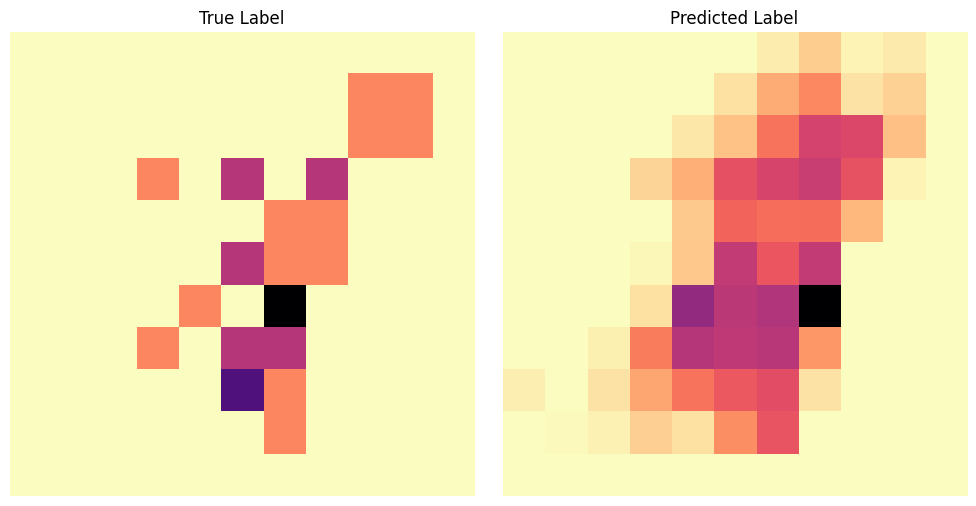

In [97]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot true label (Y_test[-1])
axes[0].imshow(Out_test[-50], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions[-50], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


## Second Model - Classification

In [98]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(11, 11, 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(11, 11, 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(22, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(64, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)

#Convolution Layers for Traffic
traffic_layer_1 = layers.Conv2D(30, (3, 3), activation='relu')(input_past_traffic_shape)
traffic_layer_2 = layers.MaxPooling2D(pool_size=(3, 1))(traffic_layer_1)
traffic_layer_3 = layers.Flatten()(traffic_layer_2)
traffic_layer_4 = layers.Dense(64, activation='relu')(traffic_layer_3)
traffic_layer_5 = layers.Dense(16, activation='relu')(traffic_layer_3)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, traffic_layer_5, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='sigmoid')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model_binary = Model(inputs=[input_past_accidents_shape, input_past_traffic_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_binary.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_99      │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 9, 9, 64)  │     13,888 │ input_layer_99[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_71    │ (None, 3, 9, 64)  │          0 │ conv2d_71[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_53          │ (None, 1728)      │          0 │ max_pooling2d_71… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_100     │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_161 (Dense)   │ (None, 24)        │     41,496 │ flatten_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 9, 9, 30)  │        300 │ input_layer_100[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_101     │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_37          │ (None, 24, 1)     │          0 │ dense_161[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_73    │ (None, 3, 9, 30)  │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 64)        │      1,472 │ input_layer_101[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 64)        │     16,896 │ reshape_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_54          │ (None, 810)       │          0 │ max_pooling2d_73… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_166 (Dense)   │ (None, 32)        │      2,080 │ dense_165[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_162 (Dense)   │ (None, 16)        │      1,040 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 16)        │     12,976 │ flatten_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_167 (Dense)   │ (None, 16)        │        528 │ dense_166[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_22         │ (None, 16)        │          0 │ dense_162[0][0],  │
│ (Multiply)          │                   │            │ dense_164[0][0],  │
│                     │                   │            │ dense_167[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 121)       │      2,057 │ multiply_22[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_38          │ (None, 11, 11, 1) │          0 │ dense_168[0][0] 

 Total params: 92,733 (362.24 KB)

 Trainable params: 92,733 (362.24 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
## Split into training and testing sets with 0.8-0.2
history_binary = model.fit([Accident_train, Traffic_train, Weather_train], Binary_Out_train, epochs=100, batch_size=32)

Epoch 1/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0586 - mae: 0.1173
Epoch 2/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0584 - mae: 0.1168
Epoch 3/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0585 - mae: 0.1170
Epoch 4/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0586 - mae: 0.1173
Epoch 5/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0582 - mae: 0.1164
Epoch 6/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0584 - mae: 0.1169
Epoch 7/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0586 - mae: 0.1174
Epoch 8/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0584 - mae: 0.1168
Epoch 9/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0583 - mae: 0.1169
Epoch 10/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0585 - mae: 0.1169
Epoch 11/100
 616/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0585 - mae: 0.1171

KeyboardInterrupt: 

In [104]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_binary.evaluate([Accident_test, Traffic_test, Weather_test], Binary_Out_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4981 - loss: 0.6933
Test Loss: 0.693259596824646
Test Accuracy: 0.49780017137527466


In [105]:
predictions_model_binary = model_binary.predict([Accident_test, Traffic_test, Weather_test])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions = (predictions_model_binary > 0.5).astype(int)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


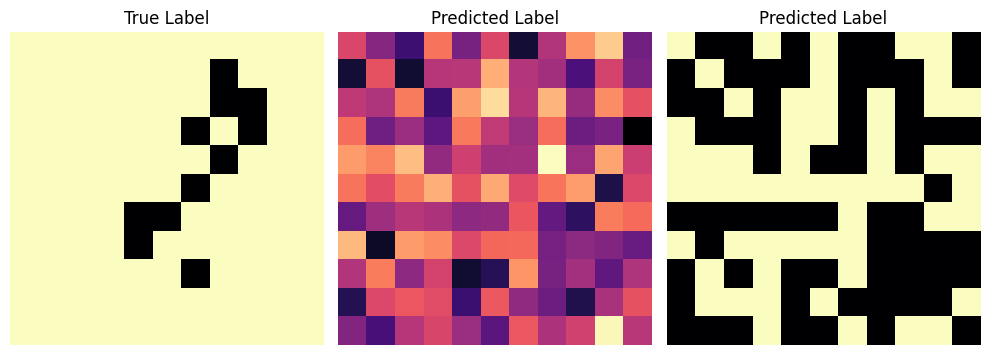

In [106]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))  # 1 row, 2 columns
i=-5000

# Plot true label (Y_test[-1])
axes[0].imshow(Binary_Out_test[i], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_model_binary[i], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[2].imshow(binary_predictions[i], cmap='magma_r')
axes[2].set_title("Predicted Label")
axes[2].axis('off')  # Hide axis for better visualization


# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()
